In [1]:
# general
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.ticker as plticker
import time
import cmocean
from tqdm.auto import tqdm

# import sys
# sys.path.append("..")

# custom
from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from diagnostics import *
from utilities import *

In [2]:
ds = xr.load_dataset(Path('thwaites/processed_data/xr_2000.nc'))
grav = pd.read_csv(Path('thwaites/processed_data/grav_leveled_2000.csv'))

grav.head()

,x,y,faa,height,msk,inv_msk,inv_pad
0,-1597500.0,-703500.0,13.440270,1200,False,0.0,True
1,-1595500.0,-703500.0,17.447241,1200,False,0.0,True
2,-1593500.0,-703500.0,20.774091,1200,False,0.0,True
3,-1591500.0,-703500.0,22.612817,1200,False,0.0,True
4,-1589500.0,-703500.0,23.245403,1200,False,0.0,False


In [3]:
terrain_g = bm_terrain_effect(ds, grav, 2670)

In [4]:
faa_grid, terrain_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (grav.faa, terrain_g))
boug_grid = faa_grid - terrain_grid

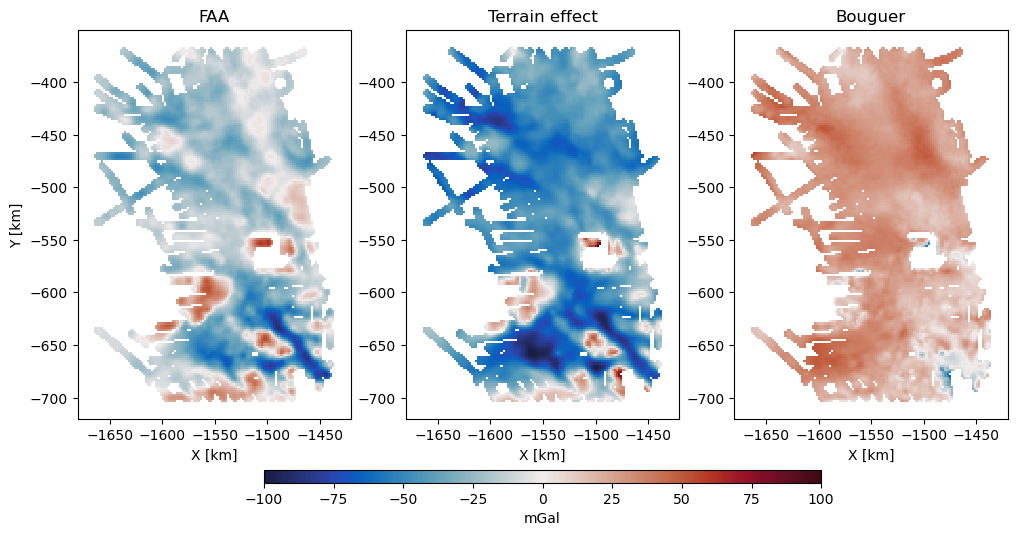

In [5]:
fig = plt.figure(figsize=(12,6))
gs = GridSpec(2, 3, height_ratios=[1, 0.03])
axs = []
for i in range(3):
    axs.append(fig.add_subplot(gs[0,i]))

#fig, axs = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, faa_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('FAA')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, terrain_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Terrain effect')
ax.set_xlabel('X [km]')

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Bouguer')
ax.set_xlabel('X [km]')

gs2 = GridSpecFromSubplotSpec(1, 100, gs[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, orientation='horizontal', label='mGal')
plt.show()

# Calculate trend with Radial Basis Functions

In [11]:
boug_dist = grav.faa.values - terrain_g

boug_trend = trend(ds, grav, boug_dist, smoothing=1e11, full_grid=True)

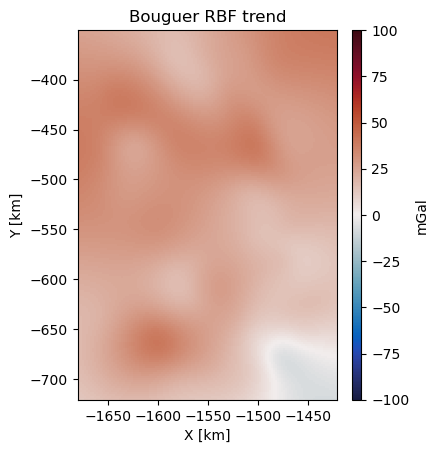

In [12]:
plt.pcolormesh(ds.x/1000, ds.y/1000, boug_trend, vmin=-100, vmax=100, cmap='cmo.balance')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bouguer RBF trend')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

## Test out different smoothings

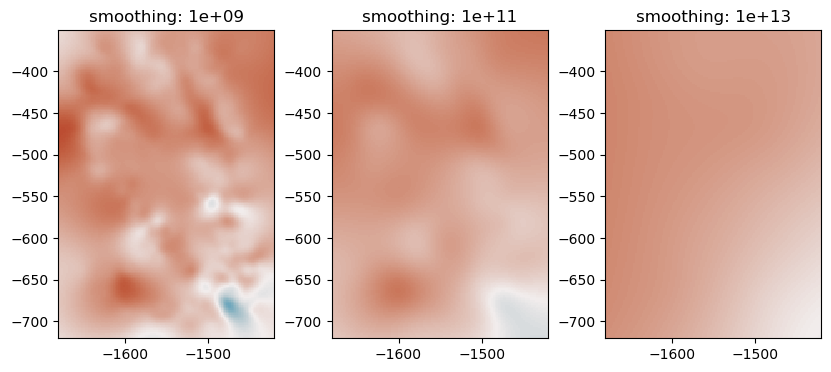

In [13]:
smoothings = [1e9, 1e11, 1e13]

fig, axs = plt.subplots(1, 3, figsize=(10,4))

for s, ax in zip(smoothings, axs):
    trend_i = trend(ds, grav, boug_dist, smoothing=s, full_grid=True)
    ax.pcolormesh(ds.x/1000, ds.y/1000, trend_i, vmin=-100, vmax=100, cmap='cmo.balance')
    ax.axis('scaled')
    ax.set_title(f'smoothing: {s:.0e}')
plt.show()

# Do trend just at gravity locations

set full_grid = False

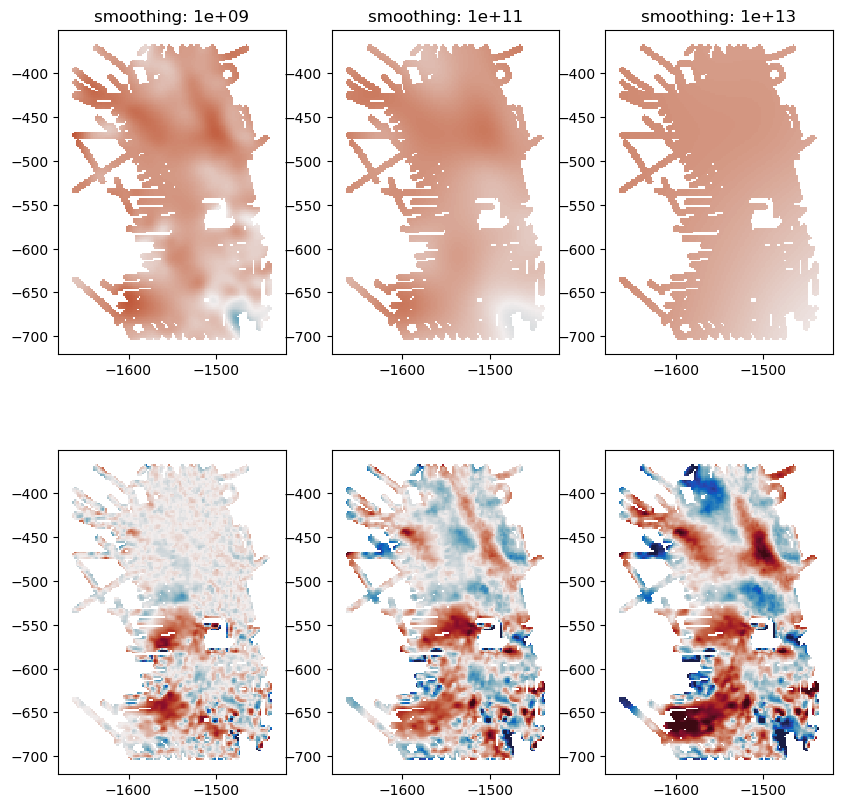

In [16]:
smoothings = [1e9, 1e11, 1e13]

fig, axs = plt.subplots(2, 3, figsize=(10,10))

for i, s in enumerate(smoothings):
    trend_i = trend(ds, grav, boug_dist, smoothing=s, full_grid=False)
    trend_i_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), trend_i)
    ax = axs[0,i]
    ax.pcolormesh(ds.x/1000, ds.y/1000, trend_i_grid, vmin=-100, vmax=100, cmap='cmo.balance')
    ax.axis('scaled')
    ax.set_title(f'smoothing: {s:.0e}')

    ax = axs[1,i]
    ax.pcolormesh(ds.x/1000, ds.y/1000, boug_grid-trend_i_grid, vmin=-20, vmax=20, cmap='cmo.balance')
    ax.axis('scaled')
plt.show()